# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import random
from scipy.stats import gaussian_kde

# A Breakdown of the GPU Memory when running `DeepSeek-R1-Distill-Qwen-14B`

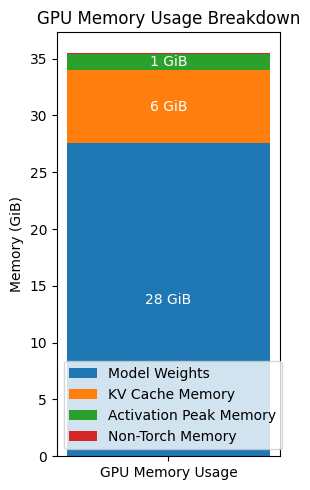

In [2]:
# Data
total_gpu_memory = 39.50
gpu_memory_utilization = 0.90
available_memory = total_gpu_memory * gpu_memory_utilization

model_weights = 27.59
non_torch_memory = 0.09
activation_peak_memory = 1.48
kv_cache_memory = 6.38

# Labels and values
labels = ['GPU Memory Usage']
model_weights_values = [model_weights]
kv_cache_memory_values = [kv_cache_memory]
activation_peak_memory_values = [activation_peak_memory]
non_torch_memory_values = [non_torch_memory]

# Plotting
fig, ax = plt.subplots(figsize=(3, 5))

bar1 = ax.bar(labels, model_weights_values, label='Model Weights')
bar2 = ax.bar(labels, kv_cache_memory_values, bottom=model_weights_values, label='KV Cache Memory')
bar3 = ax.bar(labels, activation_peak_memory_values, bottom=[i+j for i,j in zip(model_weights_values, kv_cache_memory_values)], label='Activation Peak Memory')
bar4 = ax.bar(labels, non_torch_memory_values, bottom=[i+j+k for i,j,k in zip(model_weights_values, kv_cache_memory_values, activation_peak_memory_values)], label='Non-Torch Memory')

# Adding labels and title
ax.set_ylabel('Memory (GiB)')
ax.set_title('GPU Memory Usage Breakdown')
ax.legend()

# Function to add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f} GiB',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    xytext=(0, 0),  # No offset
                    textcoords="offset points",
                    ha='center', va='center', color='white', fontsize=10, fontweight='normal')

# Add labels to the bars
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Display the plot
plt.tight_layout()
plt.show()

# KV Cache Usage Timeline with Thoughts Annotated

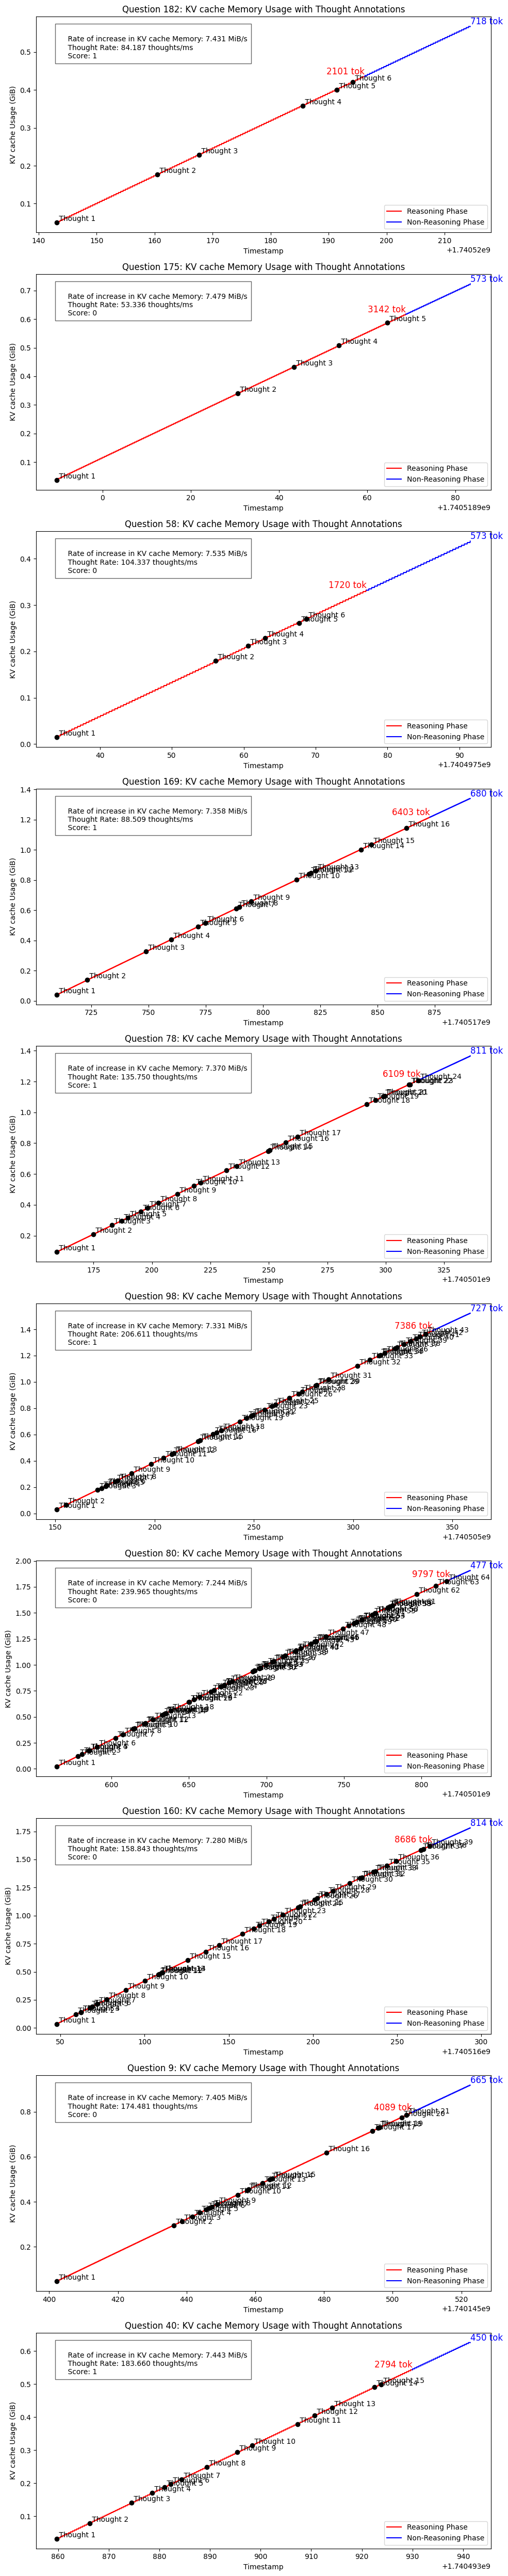

In [8]:
# Read token counts which contains the reasoning tokens counts for each question.
token_counts_path = '/Users/colinhong/Developer/vllm_experiments/r1_distill_token_counts.csv'
df_counts = pd.read_csv(token_counts_path)

# Determine the number of questions based on the number of rows in token_counts.csv
num_questions = len(df_counts)

# Prepare filenames for each question CSV (the file has a header row with timestamp,gpu_cache_usage_sys)
question_files = [f'/Users/colinhong/Developer/vllm_experiments/r1_distill_kvcache_usages/question_{i}.csv' for i in range(1, num_questions + 1)]

# Limit the number of questions to plot to avoid image size issues
max_questions_per_plot = 10
num_questions_to_plot = min(num_questions, max_questions_per_plot)  # Limit to 10 questions

# Select random question indices
selected_indices = random.sample(range(num_questions), num_questions_to_plot)
# selected_indices = [i for i in range(num_questions_to_plot)]

# Create one subplot per selected question.
fig, axes = plt.subplots(num_questions_to_plot, 1, figsize=(10, 5 * num_questions_to_plot), squeeze=False)

for plot_idx, question_idx in enumerate(selected_indices):
    ax = axes[plot_idx][0]
    file = question_files[question_idx]
    # Load the CSV for question and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[question_idx, 'Reasoning Tokens'])
    non_reasoning_count = len(timestamps) - reasoning_count

    # Compute the overall duration
    total_time = float(timestamps[-1]) - float(timestamps[0])
    gpu_rate = (usage[-1] - usage[0]) / total_time * 1024 if total_time > 0 else 0

    # Convert thought positions string to a list and compute thought rate.
    thought_positions_str = df_counts.loc[question_idx, 'Thought Positions']
    thought_positions = ast.literal_eval(thought_positions_str)
    thought_rate = len(thought_positions) / total_time * 1000 if total_time > 0 else 0

    gpu_info_labels = f"""
    Rate of increase in KV cache Memory: {gpu_rate:.3f} MiB/s
    Thought Rate: {thought_rate:.3f} thoughts/ms
    Score: {df_counts.loc[question_idx, 'Score']}"""

    ax.text(0.05, 0.95, gpu_info_labels,
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.6, pad=5))

    # Plot reasoning phase (first reasoning_count rows) in red.
    if reasoning_count > 0:
        ax.plot(timestamps[:reasoning_count], usage[:reasoning_count],
                color='red', label='Reasoning Phase')
        ax.text(timestamps[reasoning_count - 1], usage[reasoning_count - 1],
                f'{reasoning_count} tok', color='red', fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')

    # Plot non-reasoning phase (remaining rows) in blue.
    if reasoning_count < len(timestamps):
        ax.plot(timestamps[reasoning_count:], usage[reasoning_count:],
                color='blue', label='Non-Reasoning Phase')
        ax.text(timestamps[-1], usage[-1],
                f'{non_reasoning_count} tok', color='blue', fontsize=12,
                verticalalignment='bottom', horizontalalignment='left')

    # Mark and annotate each thought position from token_counts.csv
    for j, pos in enumerate(thought_positions):
        if pos < len(timestamps):
            ts = timestamps[pos]
            usage_val = usage[pos]
            ax.plot(ts, usage_val, 'ko', markersize=6)
            ax.text(ts, usage_val, f' Thought {j+1}', color='black', fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('KV cache Usage (GiB)')
    ax.set_title(f'Question {question_idx+1}: KV cache Memory Usage with Thought Annotations')
    ax.legend()

plt.tight_layout()
plt.show()

# KV Cache Usage Categorized by Stage

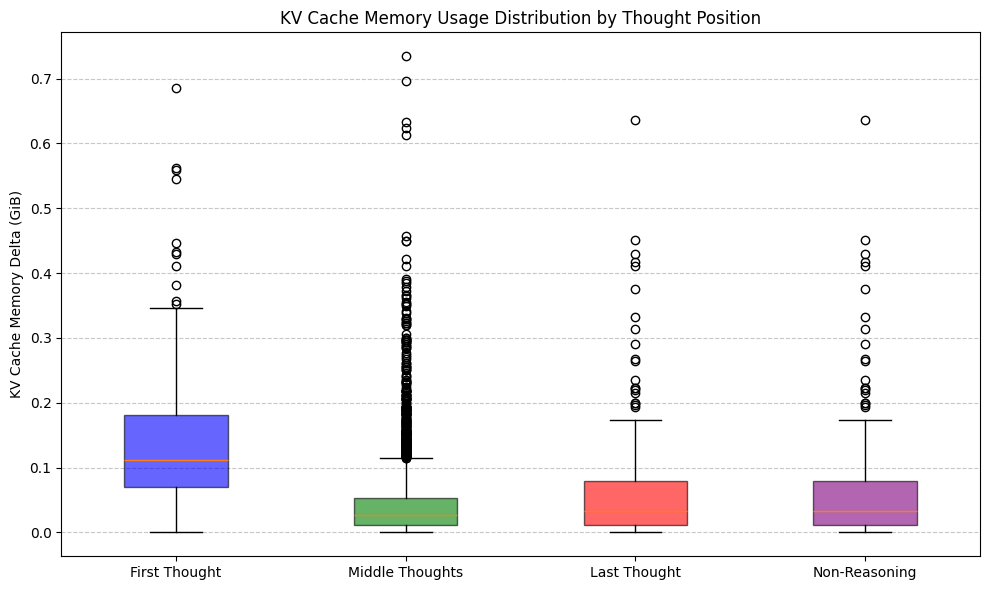

In [ ]:
# Arrays to store data from all questions
all_first_deltas = []
all_last_deltas = []
all_middle_deltas = []
non_reasoning_deltas = []

for idx, file in enumerate(question_files):
    # Load the data
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory
    
    # Get thought positions
    thought_positions_str = df_counts.loc[idx, 'Thought Positions']
    thought_positions = ast.literal_eval(thought_positions_str)
    
    if not thought_positions or max(thought_positions) >= len(usage):
        continue
        
    # Calculate memory at each thought position
    thought_memories = [usage[pos] for pos in thought_positions if pos < len(usage)]
    first_non_reasoning_usage = usage[thought_positions[-1] + 1] if thought_positions[-1] < len(usage) - 1 else 0
    
    if not thought_memories:
        continue

    if len(thought_memories) == 1:
        all_first_deltas.append(first_non_reasoning_usage - thought_memories[0])
    
    else:
        # First delta (start to first thought)
        first_delta = thought_memories[1] - thought_memories[0]
        all_first_deltas.append(first_delta)
        
        # Middle deltas (between consecutive thoughts)
        for i in range(2, len(thought_memories)-1):
            delta = thought_memories[i] - thought_memories[i-1]
            all_middle_deltas.append(delta)
        
        # Last delta
        last_delta = thought_memories[-1] - thought_memories[-2]
        all_last_deltas.append(last_delta)

    # Non-reasoning delta (last thought to end)
    if thought_positions[-1] < len(usage) - 1:
        non_reasoning_delta = usage[-1] - thought_memories[-1]
        non_reasoning_deltas.append(last_delta)

# Add a second plot showing boxplots for direct comparison
fig_box, ax_box = plt.subplots(figsize=(10, 6))
box_data = [all_first_deltas, all_middle_deltas, all_last_deltas, non_reasoning_deltas]
box_labels = ['First Thought', 'Middle Thoughts', 'Last Thought', 'Non-Reasoning']
box_colors = ['blue', 'green', 'red', 'purple']

bp = ax_box.boxplot(box_data, patch_artist=True, tick_labels=box_labels)

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax_box.set_ylabel('KV Cache Memory Delta (GiB)')
ax_box.set_title('KV Cache Memory Usage Distribution by Thought Position')
ax_box.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Box plot of KV Cache Usage at the End of Reasoning vs. Thought Count

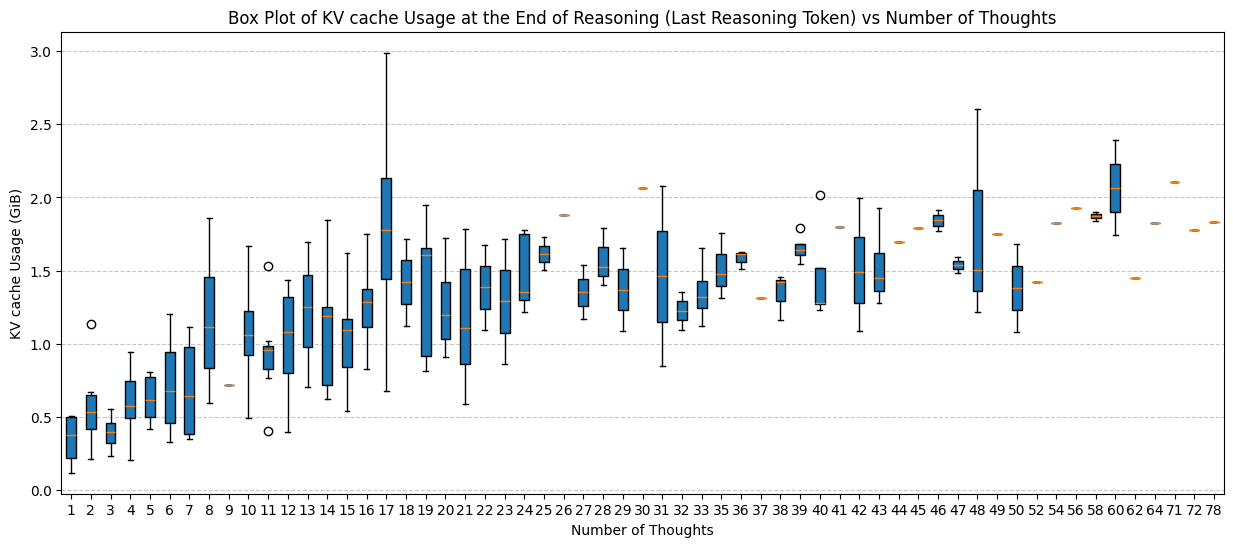

In [40]:
# Dictionary to group GPU usage values by the number of thoughts.
grouped_usage = {}

for idx, file in enumerate(question_files):
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values.astype(float)
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    
    # Only process if there is a reasoning phase
    if reasoning_count > 0:
        # KV cache usage at the last token for the reasoning phase.
        last_gpu_usage = usage[reasoning_count - 1]
        
        # Get number of thoughts for this question.
        thought_positions_str = df_counts.loc[idx, 'Thought Positions']
        thought_positions = ast.literal_eval(thought_positions_str)
        num_thoughts = len(thought_positions)
        
        # Group by num_thoughts.
        grouped_usage.setdefault(num_thoughts, []).append(last_gpu_usage)

# Prepare data for the boxplot.
# Sort the groups by the number of thoughts.
sorted_keys = sorted(grouped_usage.keys())
data = [grouped_usage[k] for k in sorted_keys]

plt.figure(figsize=(15, 6))
plt.boxplot(data, tick_labels=sorted_keys, patch_artist=True)
plt.xlabel('Number of Thoughts')
plt.ylabel('KV cache Usage (GiB)')
plt.title('Box Plot of KV cache Usage at the End of Reasoning (Last Reasoning Token) vs Number of Thoughts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Cumulative Mean KV cache Usage by Thought Number with Error Bars

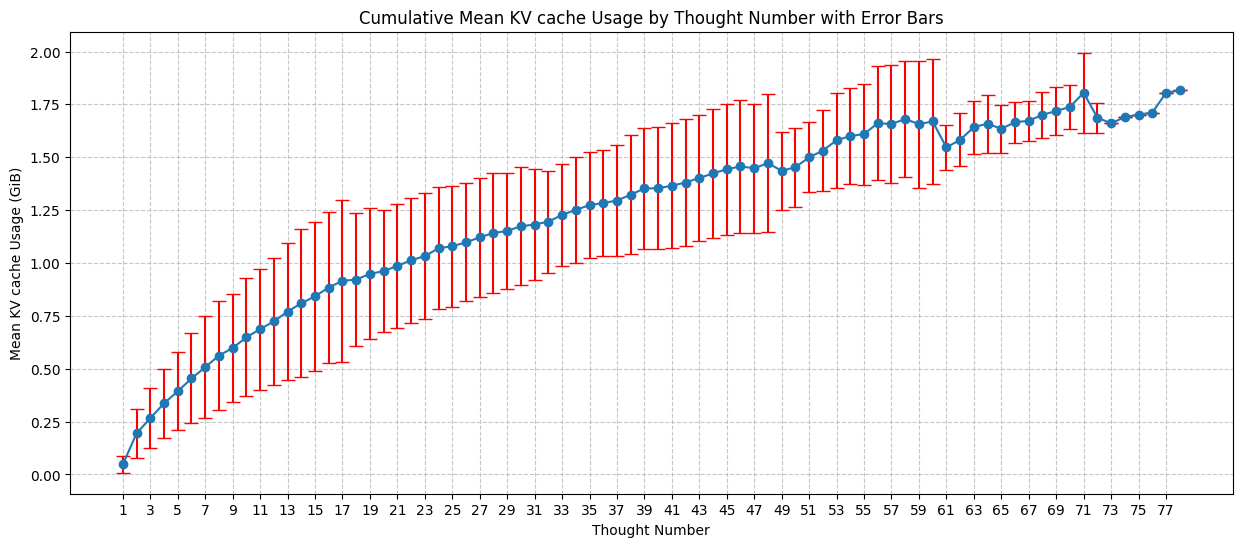

In [ ]:
# Dictionary to accumulate usage values by thought number (1-indexed)
thought_usage = {}

for idx, file in enumerate(question_files):
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    
    # Only process if there is a reasoning phase
    if reasoning_count > 0:
        # Get all thought positions for this question.
        thought_positions_str = df_counts.loc[idx, 'Thought Positions']
        thought_positions = ast.literal_eval(thought_positions_str)
        
        # For each thought, record the KV cache usage at that token index.
        for i, pos in enumerate(thought_positions):
            current_usage = usage[pos]
            thought_usage.setdefault(i+1, []).append(current_usage)

# Compute the mean and standard deviation for each thought number.
sorted_thoughts = sorted(thought_usage.keys())
mean_usage = [np.mean(thought_usage[i]) for i in sorted_thoughts]
std_usage = [np.std(thought_usage[i]) for i in sorted_thoughts]

# Plot the line graph with error bars (std)
plt.figure(figsize=(15, 6))
plt.errorbar(sorted_thoughts, mean_usage, yerr=std_usage, fmt='-o', capsize=5, ecolor='red')
plt.xlabel('Thought Number')
plt.xticks([i for i in range(1, len(sorted_thoughts) + 1, 2)])
plt.ylabel('Mean KV Cache Usage (GiB)')
plt.title('Cumulative Mean KV cache Usage by Thought Number with Error Bars')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Box Plot of KV Cache Usage by Thought Number

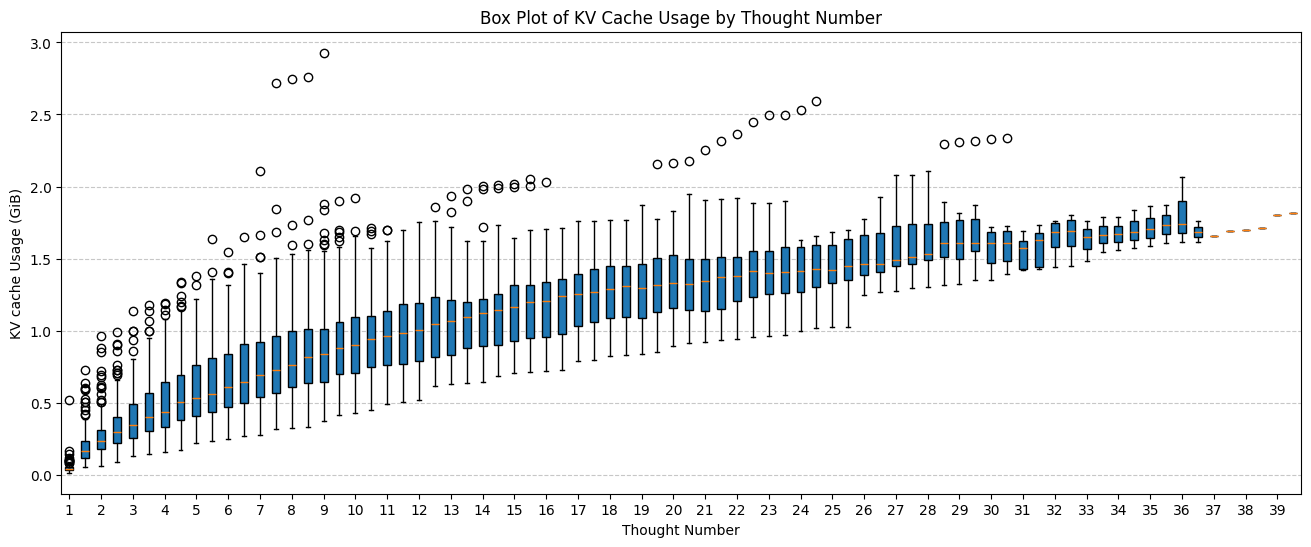

In [47]:
# Dictionary to accumulate usage values by thought number (1-indexed)
thought_usage = {}

for idx, file in enumerate(question_files):
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    usage = df_question['gpu_cache_usage_perc'].values * kv_cache_memory

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    
    # Process only if there is a reasoning phase
    if reasoning_count > 0:
        # Get all thought positions for this question.
        thought_positions_str = df_counts.loc[idx, 'Thought Positions']
        thought_positions = ast.literal_eval(thought_positions_str)
        
        # For each thought, record the KV cache usage at that token index.
        for i, pos in enumerate(thought_positions):
            current_usage = usage[pos]
            thought_usage.setdefault(i+1, []).append(current_usage)

# Prepare data for box plot: sort by thought number.
sorted_thoughts = sorted(thought_usage.keys())
data = [thought_usage[i] for i in sorted_thoughts]

plt.figure(figsize=(16, 6))
plt.boxplot(data, tick_labels=sorted_thoughts, patch_artist=True)
plt.xlabel('Thought Number')
plt.xticks([i for i in range(1, len(sorted_thoughts) + 1, 2)])
plt.ylabel('KV cache Usage (GiB)')
plt.title('Box Plot of KV Cache Usage by Thought Number')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Distribution of Thought Count with KDE

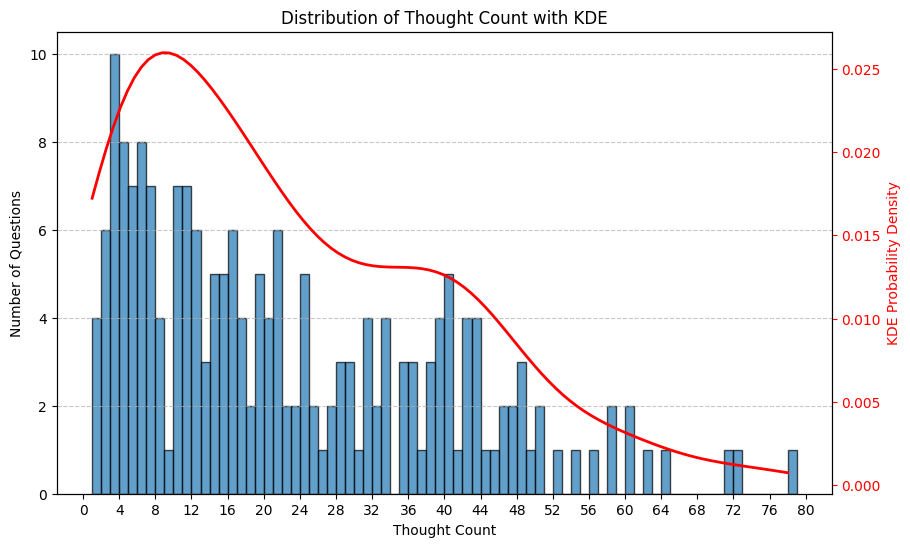

In [ ]:
# Load the token_counts.csv file
df_counts = pd.read_csv("token_counts.csv")

# Extract the Thought Count column
thought_count = df_counts["Thought Count"]

# Define bins to cover the full range of Thought Counts
bins = range(int(thought_count.min()), int(thought_count.max()) + 2)

# Create a figure and the primary axis for the histogram.
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram for Thought Count on ax1.
ax1.hist(thought_count, bins=bins, edgecolor="black", alpha=0.7)
ax1.set_xlabel("Thought Count")
ax1.set_ylabel("Number of Questions")
ax1.set_title("Distribution of Thought Count with KDE")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
ax1.xaxis.set_major_locator(plt.MaxNLocator(25))

# Compute the KDE over a dense grid.
x_d = np.linspace(thought_count.min(), thought_count.max(), 100)
kde = gaussian_kde(thought_count)
density = kde(x_d)

# Create a twin axis (initially on the right).
ax2 = ax1.twinx()
ax2.spines["right"].set_visible(True)

# Plot the KDE on ax2.
ax2.plot(x_d, density, color="red", linewidth=2)
ax2.set_ylabel("KDE Probability Density", color="red")
ax2.tick_params(axis="y", colors="red")

plt.show()

# Distribution of Thought Count

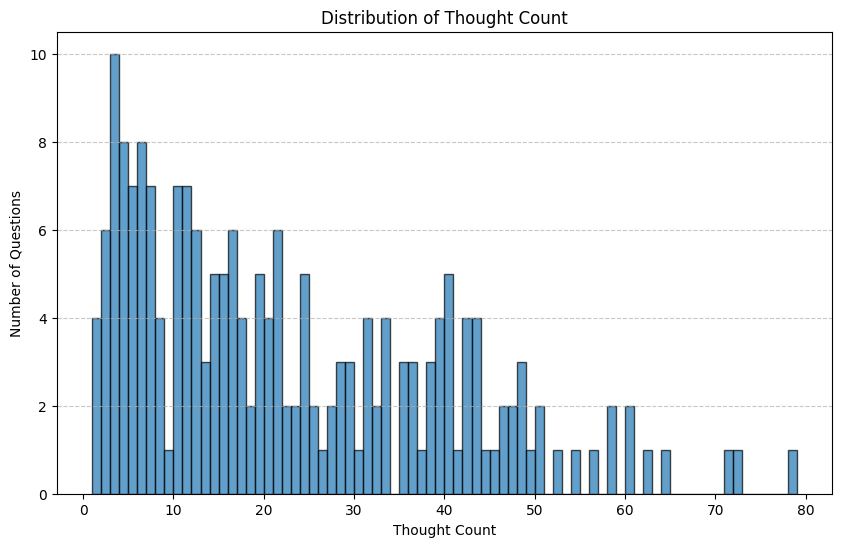

In [ ]:
# Load the token_counts.csv file
df_counts = pd.read_csv("token_counts.csv")

# Extract the Thought Count column
thought_count = df_counts["Thought Count"]

# Define bins to cover the full range of Thought Counts
bins = range(int(thought_count.min()), int(thought_count.max()) + 2)

# Plot the histogram for the Thought Count distribution
plt.figure(figsize=(10, 6))
plt.hist(thought_count, bins=bins, edgecolor="black", alpha=0.7)
plt.xlabel("Thought Count")
plt.ylabel("Number of Questions")
plt.title("Distribution of Thought Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Correlation between Thought Count and Score

<Figure size 1000x600 with 0 Axes>

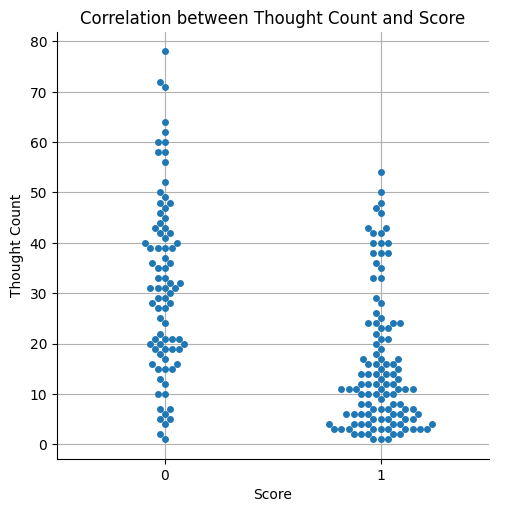

In [52]:
plt.figure(figsize=(10, 6))
sns.catplot(data=df_counts, x='Score', y='Thought Count', kind="swarm")
plt.title('Correlation between Thought Count and Score')
plt.xlabel('Score')
plt.ylabel('Thought Count')
plt.grid(True)
plt.show()

In [13]:
# Calculate the accuracy
accuracy = df_counts['Score'].mean() * 100

print(f'Accuracy of DeepSeek-R1-Distill-Qwen-14B: {accuracy:.2f}')
print('Original DeepSeek-R1-Distill-Qwen-14B model achieves 59.1% on GPQA Diamond')

Accuracy of DeepSeek-R1-Distill-Qwen-14B: 58.08
Original DeepSeek-R1-Distill-Qwen-14B model achieves 59.1% on GPQA Diamond
